In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import math
import random

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
#from tensorflow import set_random_seed
#from tensorflow.python.client import device_lib
import datetime as dt
import os
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim


In [3]:
# tf.__version__

In [4]:
saved_model_dir = "saved_model/general_full_data_training/"
if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)
# tf.reset_default_graph()

saving_dir = "explain/general_full_data_training/"
if not os.path.exists(saving_dir):
    os.makedirs(saving_dir)

# fix random seed for reproducibility
np.random.seed(7)
torch.manual_seed(7)

NUM_LAYERS = 1
HIDDEN_SIZE = 64
TRAIN_EPOCHS = 200

print_iter = 50

TRAIN_NUM_STEPS = 4
TRAIN_BATCHES = 2048
TEST_SIZE = 0

seq_length = 4
# with open('pd_list_full_with_rewards_original_seq4.pkl', 'rb') as f:
#     pd_list = pickle.load(f)
with open('cross_validation/diff_seq_lengths/4/huge_pd_shuffled_with_rewards_original_seq4_SHUFFLED.pkl', 'rb') as f:
    huge_pd = pickle.load(f)

In [5]:
def my_train_test_split(X, y, sequence_length, test_size=TEST_SIZE, debug_print=False):
    train_samples = int(np.ceil(X.shape[0] * (1 - test_size)))
    test_samples = int(np.floor(X.shape[0] * test_size))
    if debug_print: print("train samples:", train_samples, " test samples:", test_samples)
    divide_train = train_samples % sequence_length == 0
    while not (divide_train):
        train_samples += 1
        divide_train = train_samples % sequence_length == 0

    divide_test = test_samples % sequence_length == 0
    while not (divide_test):
        test_samples -= 1
        divide_test = test_samples % sequence_length == 0

    print("train can divide by ", sequence_length, "?", divide_train, "num train samples = ", train_samples)
    print("test can divide by ", sequence_length, "?", divide_test, "num train samples = ", test_samples)
    X_train = X[0:train_samples]
    if debug_print: print("X_train indices are 0 to:", train_samples)
    X_test = X[train_samples:].copy()
    if debug_print: print("X_test indices are {} to {}:".format(train_samples, len(X)))
    y_train = y[0:train_samples]
    if debug_print: print("y_train indices are {} to {}:".format(0, train_samples))
    y_test = y[train_samples:train_samples+len(X_test)]
    if debug_print: print("y_test indices are {} to {}:".format(train_samples, len(y)))
    # TODO: enter assertion to check sizes X_train/test and the samples computed earlier
    # TODO: assert of train size = labels etc
    return X_train, X_test, y_train, y_test

In [6]:
cur_data = huge_pd.copy()

cur_data['choice'] = cur_data.choice.apply(lambda x: x - 1)
cur_data['prev_choice'] = cur_data.prev_choice.apply(lambda x: x - 1)  

# !! Added: remove choices and prev_choice nan and -2 values 

cur_data = cur_data[cur_data.choice >=0]
cur_data = cur_data[cur_data.prev_choice >=0]



# X = cur_data.drop(columns = ['orig_choice_num','index','choice','user','time','reward','payoff_structure','reward_1','reward_2','reward_3','reward_4'])
X = cur_data.drop(
    columns=['index', 'choice', 'user', 'time', 'reward', 'payoff_structure', 'reward_1', 'reward_2', 'reward_3',
             'reward_4'])
X_prev = X.prev_choice.to_numpy()
X_prev = F.one_hot(torch.tensor(X_prev, dtype = torch.int64), num_classes=4)

y = cur_data.choice
num_of_classes = len(y.unique())
y = y.to_numpy()
y = torch.nn.functional.one_hot(torch.tensor(y, dtype=torch.int64), num_classes = 4)

new_X = []
for prev_choice, prev_reward in zip(X_prev, X.prev_reward):
    new_i = np.append(prev_choice, prev_reward)
    new_X.append(new_i)
new_X = np.array(new_X)

seq_data = cur_data.reset_index(drop=True).copy()

In [7]:
def is_continous_sequence(choice_numbers):
# gets a list and return True if the sequence is continuous without gaps, otherwise return False
    for c, choice_number in enumerate(choice_numbers):
        if c==1:
            continue
        if choice_numbers[c] - choice_numbers[c-1] > 1:
            return False
    return True

In [8]:
start = 0
end = 4

continuous_counter = 0
not_continuous_counter = 0

more_than_one_gap_seq = []
for i in range(start, seq_data.shape[0],4):
    if i == 0 :
        start = 0
        end = start + 4
    start = i
    end = start + 4
    cur_orig_choices = list(seq_data[start:end]['orig_choice_num'])
    if is_continous_sequence(cur_orig_choices):
        continuous_counter += 1
    else:
        not_continuous_counter += 1
        more_than_one_gap_seq.append(cur_orig_choices)

In [9]:
seq_data[start:end]

,index,user,choice,reward,time,payoff_structure,reward_1,reward_2,reward_3,reward_4,orig_choice_num,prev_choice,prev_reward
536656,20,250.0,0.0,55.0,1126.0,2.0,55.0,87.0,46.0,32.0,20.0,3.0,27.0


In [10]:
seq_data.shape[0]//4

134164

In [12]:
assert(continuous_counter+not_continuous_counter==seq_data.shape[0]//4)

AssertionError: 

In [11]:
continuous_counter

52441

In [12]:
not_continuous_counter # on devrait avoir 5177

81724

In [13]:
def how_continous_sequence(choice_numbers):
# gets a list and returns : the highest gap in the sequence, total gap
    highest_gap = 0
    gap_sum = 0
    for c, choice_number in enumerate(choice_numbers):
        if c==1:
            continue
        gap = choice_numbers[c] - choice_numbers[c-1] 
        if gap>highest_gap:
            highest_gap = gap
        gap_sum += gap
        
    return highest_gap, gap_sum

In [14]:
# check the more_than_one_gap_seq - how many gaps there is 
highest_gaps = []
gaps_sums = []
for i in range(len(more_than_one_gap_seq)):
    highest_gap, gap_sum = how_continous_sequence(more_than_one_gap_seq[i])
    highest_gaps.append(highest_gap)
    gaps_sums.append(gap_sum)

In [15]:
from collections import Counter

In [16]:
highest_gaps_counter = Counter(highest_gaps)
gaps_sums_counter = Counter(gaps_sums)

In [17]:
highest_gaps_counter

Counter({2.0: 1084,
         3.0: 1262,
         45.0: 792,
         34.0: 922,
         54.0: 691,
         62.0: 656,
         95.0: 437,
         35.0: 897,
         16.0: 968,
         17.0: 997,
         71.0: 596,
         105.0: 354,
         121.0: 215,
         100.0: 361,
         70.0: 608,
         14.0: 1037,
         117.0: 227,
         133.0: 109,
         22.0: 941,
         51.0: 771,
         60.0: 670,
         41.0: 823,
         32.0: 849,
         75.0: 541,
         28.0: 937,
         57.0: 686,
         73.0: 544,
         29.0: 913,
         7.0: 1095,
         46.0: 763,
         39.0: 850,
         9.0: 1059,
         12.0: 1082,
         69.0: 617,
         10.0: 1057,
         31.0: 878,
         33.0: 893,
         65.0: 617,
         30.0: 871,
         44.0: 815,
         58.0: 727,
         78.0: 521,
         23.0: 923,
         48.0: 787,
         26.0: 959,
         40.0: 842,
         89.0: 440,
         64.0: 572,
         61.0: 678,
         68.

---------

In [18]:
#X_train, X_test, y_train, y_test = my_train_test_split(new_X, y, seq_length, test_size=TEST_SIZE, debug_print=True)
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2, random_state = 42,shuffle=False)

possible_samples = int(X.shape[0] / seq_length)
possible_samples_train = int(X_train.shape[0] / seq_length)
possible_samples_test = int(X_test.shape[0] / seq_length)
possible_labels_train = int(y_train.shape[0] / seq_length)
possible_labels_test = int(y_test.shape[0] / seq_length)

# reshape X to be [samples, time steps, features]
X_train = np.reshape(X_train[:-1], (possible_samples_train, seq_length, X_train.shape[1]))

# y_cat_train = np.reshape(y_train, (seq_length, possible_samples_train, y_train.shape[1]))    # coursera's shape
y_cat_train = np.reshape(y_train[:-1], (possible_samples_train, seq_length, y_train.shape[1]))

X_test = np.reshape(X_test, (possible_samples_test, seq_length, X_test.shape[1]))
y_cat_test = np.reshape(y_test, (possible_labels_test, seq_length, y_test.shape[1]))

num_of_samples = y_cat_test.shape[0]
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

<ipython-input-18-753ca3a3d59f>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype = torch.float32)
<ipython-input-18-753ca3a3d59f>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype = torch.float32)


In [19]:
class Model(nn.Module):
    def __init__(self, all_x, all_y, output_size, seq_length, batch_size = TRAIN_BATCHES, hidden_size=HIDDEN_SIZE):
        super(Model, self).__init__()

        self.output_size = output_size
        self.seq_length = seq_length
        self.hidden_size = hidden_size

        # Initialize LSTM cell
        self.cell = nn.LSTMCell(input_size=all_x.size(-1), hidden_size=hidden_size)

        # Linear layer parameters
        self.softmax_w = nn.Parameter(torch.rand(hidden_size, output_size))
        self.softmax_b = nn.Parameter(torch.rand(output_size))

        # Cross-entropy loss
        self.criterion = nn.CrossEntropyLoss()

        # Data loader
        self.data_loader = self.create_data_loader(all_x, all_y)

        # Adam optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, betas=(0.9, 0.9999))

    def create_data_loader(self, all_x, all_y, batch_size=TRAIN_BATCHES):
        dataset = torch.utils.data.TensorDataset(all_x, all_y)
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def forward(self, x, y):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Initialize hidden state
        h_t, c_t = torch.zeros(batch_size, self.hidden_size), torch.zeros(batch_size, self.hidden_size)
        states = (h_t, c_t)

        # Forward pass through LSTM cell
        output = []
        for i in range(seq_len):
            states = self.cell(x[:, i, :], states)
            output.append(states[0])

        # Reshape output
        output = torch.stack(output, dim=1).view(-1, self.hidden_size)

        # Linear layer
        logits = torch.matmul(output, self.softmax_w) + self.softmax_b

        # Reshape logits for sequence loss
        logits_reshaped = logits.view(batch_size, seq_len, -1)[:, -1, :]
       
        # Cross-entropy loss
        loss = self.criterion(logits_reshaped, y.float())

        # Calculate accuracy
        _, predictions = torch.max(logits_reshaped, 1)
        _, true = torch.max(y, 1)

        accuracy = torch.mean((predictions == true).float())
        return loss, accuracy

In [20]:
def train(all_x_train, all_y_train, model_path, output_size=4, print_iter=50, test = False, all_x_test = None, all_y_test = None):
    # Setup data and models
    model = Model(all_x_train, all_y_train, output_size=output_size, seq_length=TRAIN_NUM_STEPS)
    
    accs_over_epochs = []
    loss_over_epochs = []
    loss_test_over_epochs = []
    accs_test_over_epochs = []
    counter = 0

    for epoch in range(TRAIN_EPOCHS):
        accs_over_batches = []
        loss_over_batches = []

        # Reset the DataLoader iterator for each epoch
        data_iter = iter(model.data_loader)

        try:
            while True:
                # Get the next batch
                x_batch, y_batch = next(data_iter)

                # Forward pass
                loss, accuracy = model(x_batch, y_batch)

                # Backward pass and optimization
                model.optimizer.zero_grad()
                loss.backward()
                model.optimizer.step()

                counter += 1
                accs_over_batches.append(accuracy.item())
                loss_over_batches.append(loss.item())

                if counter % print_iter == 0:
                    print(f"Epoch [{epoch + 1}/{TRAIN_EPOCHS}], Step [{counter}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")
        
        except StopIteration:
            print(f"Finished epoch {epoch + 1}, acc {np.mean(accs_over_batches):.4f}, loss {np.mean(loss_over_batches):.4f}")
            accs_over_epochs.append(np.mean(accs_over_batches))
            loss_over_epochs.append(np.mean(loss_over_batches))
            
            if test : 
                loss_test, accuracy_test = model(all_x_test, all_y_test)
                loss_test_over_epochs.append(loss_test)
                accs_test_over_epochs.append(accuracy_test)
            
            
    print("---------------------------------------------------------------")
    print(f"Final Accuracy: {accs_over_epochs[-1]:.4f}")
    print(f"Average Accuracy: {np.mean(accs_over_epochs):.4f}")
    print("Final Loss:")
    print(f"{loss_over_epochs[-1]:.4f}")
    print(f"Average Loss: {np.mean(loss_over_epochs):.4f}")

    # Save the model (if needed)
    torch.save(model.state_dict(), model_path)

    return accs_over_epochs, loss_over_epochs, loss_test_over_epochs, accs_test_over_epochs

In [21]:
def test(all_x, all_y, model_path, output_size=4, print_iter=50, print_results=True):
   
    model = Model(all_x, all_y, output_size=output_size, seq_length=TRAIN_NUM_STEPS)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    counter = 0
    # print("will run for {} steps in total".format(len(all_x)))
    accs_over_batches = []
    loss_over_batches = []
    
    data_iter = iter(model.data_loader) # reset data_loader
    
    try:
        # As long as there are elements execute the block below
        while True:
            
            # Get the next batch
            x_batch, y_batch = next(data_iter)

            # Forward pass
            loss, accuracy = model(x_batch, y_batch)

            counter = counter + 1
            accs_over_batches.append(accuracy.item())
            loss_over_batches.append(loss.item())
            
    except StopIteration:
    # Code exécuté lorsqu'il n'y a plus rien dans l'itérateur
        if print_results:
            print("finished testing, acc {} loss {}".format(np.mean(accs_over_batches), np.mean(loss_over_batches)))
            print(accs_over_batches)

        if print_results:
            print("---------------------------------------------------------------")
            # print(accs_over_batches[-1])
            print(np.mean(accs_over_batches))
            print("loss:")
            # print(loss_over_batches[-1])
            print(np.mean(loss_over_batches))
        # do a final save
        # saver.save(sess, save_path)

    return accs_over_batches, loss_over_batches

In [22]:
X_train[12, :, :], y_cat_train[12, :, :]  # la dernière ligne d'un élement de y_cat correspond au 5ème choix de la séquence 

(tensor([[ 0.,  1.,  0.,  0., 38.],
         [ 0.,  0.,  0.,  1., 52.],
         [ 0.,  0.,  0.,  1., 56.],
         [ 0.,  1.,  0.,  0., 70.]]),
 tensor([[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 1, 0],
         [0, 1, 0, 0]]))

In [23]:
### TRAINING PART ####

model_path = saved_model_dir + "torch_model"
accuracies_per_epoch, losses_per_epoch, accs_test, loss_test = train(X_train, y_cat_train[:,-1,:], model_path = model_path, test = True, \
                                                                    all_x_test = X_test, all_y_test = y_cat_test[:,-1,:])
train_results = accuracies_per_epoch, losses_per_epoch
with open(os.path.join(saved_model_dir, 'model_with_torch_batch{}_results.pkl'.format(TRAIN_BATCHES)), 'wb') as handle:
    pickle.dump(train_results, handle)

# accs_over_batches, losses_over_batches = test(X_test, y_cat_test[:,-1,:], model_path = model_path)


Epoch [1/200], Step [50], Loss: 1.2134, Accuracy: 0.4023
Finished epoch 1, acc 0.4097, loss 1.2995
Epoch [2/200], Step [100], Loss: 1.1382, Accuracy: 0.5615
Finished epoch 2, acc 0.5380, loss 1.1674
Epoch [3/200], Step [150], Loss: 1.0244, Accuracy: 0.6001
Finished epoch 3, acc 0.5854, loss 1.0475
Epoch [4/200], Step [200], Loss: 0.9729, Accuracy: 0.6260
Finished epoch 4, acc 0.6175, loss 0.9852
Epoch [5/200], Step [250], Loss: 0.9194, Accuracy: 0.6587
Finished epoch 5, acc 0.6364, loss 0.9537
Epoch [6/200], Step [300], Loss: 0.9042, Accuracy: 0.6641
Finished epoch 6, acc 0.6465, loss 0.9343
Epoch [7/200], Step [350], Loss: 0.9122, Accuracy: 0.6665
Finished epoch 7, acc 0.6531, loss 0.9193
Epoch [8/200], Step [400], Loss: 0.8947, Accuracy: 0.6689
Finished epoch 8, acc 0.6563, loss 0.9078
Epoch [9/200], Step [450], Loss: 0.9047, Accuracy: 0.6528
Finished epoch 9, acc 0.6599, loss 0.8990
Epoch [10/200], Step [500], Loss: 0.8828, Accuracy: 0.6587
Finished epoch 10, acc 0.6620, loss 0.8917

Finished epoch 78, acc 0.6863, loss 0.8387
Epoch [79/200], Step [4150], Loss: 0.8475, Accuracy: 0.6812
Finished epoch 79, acc 0.6854, loss 0.8412
Epoch [80/200], Step [4200], Loss: 0.8522, Accuracy: 0.6821
Finished epoch 80, acc 0.6861, loss 0.8401
Epoch [81/200], Step [4250], Loss: 0.8254, Accuracy: 0.6973
Finished epoch 81, acc 0.6874, loss 0.8389
Epoch [82/200], Step [4300], Loss: 0.8489, Accuracy: 0.6846
Finished epoch 82, acc 0.6865, loss 0.8383
Epoch [83/200], Step [4350], Loss: 0.8499, Accuracy: 0.6875
Finished epoch 83, acc 0.6871, loss 0.8376
Epoch [84/200], Step [4400], Loss: 0.8371, Accuracy: 0.6885
Epoch [84/200], Step [4450], Loss: 0.8002, Accuracy: 0.7070
Finished epoch 84, acc 0.6871, loss 0.8381
Epoch [85/200], Step [4500], Loss: 0.8532, Accuracy: 0.6743
Finished epoch 85, acc 0.6870, loss 0.8386
Epoch [86/200], Step [4550], Loss: 0.8310, Accuracy: 0.6855
Finished epoch 86, acc 0.6869, loss 0.8376
Epoch [87/200], Step [4600], Loss: 0.8163, Accuracy: 0.6997
Finished epoc

Finished epoch 154, acc 0.6927, loss 0.8259
Epoch [155/200], Step [8200], Loss: 0.8088, Accuracy: 0.6899
Finished epoch 155, acc 0.6931, loss 0.8247
Epoch [156/200], Step [8250], Loss: 0.8035, Accuracy: 0.7061
Finished epoch 156, acc 0.6939, loss 0.8240
Epoch [157/200], Step [8300], Loss: 0.8065, Accuracy: 0.6938
Finished epoch 157, acc 0.6933, loss 0.8238
Epoch [158/200], Step [8350], Loss: 0.8489, Accuracy: 0.6914
Finished epoch 158, acc 0.6940, loss 0.8240
Epoch [159/200], Step [8400], Loss: 0.8340, Accuracy: 0.6934
Finished epoch 159, acc 0.6934, loss 0.8237
Epoch [160/200], Step [8450], Loss: 0.7968, Accuracy: 0.6987
Finished epoch 160, acc 0.6930, loss 0.8231
Epoch [161/200], Step [8500], Loss: 0.7942, Accuracy: 0.7007
Finished epoch 161, acc 0.6932, loss 0.8237
Epoch [162/200], Step [8550], Loss: 0.8374, Accuracy: 0.6919
Finished epoch 162, acc 0.6932, loss 0.8243
Epoch [163/200], Step [8600], Loss: 0.8479, Accuracy: 0.6841
Finished epoch 163, acc 0.6937, loss 0.8232
Epoch [164/

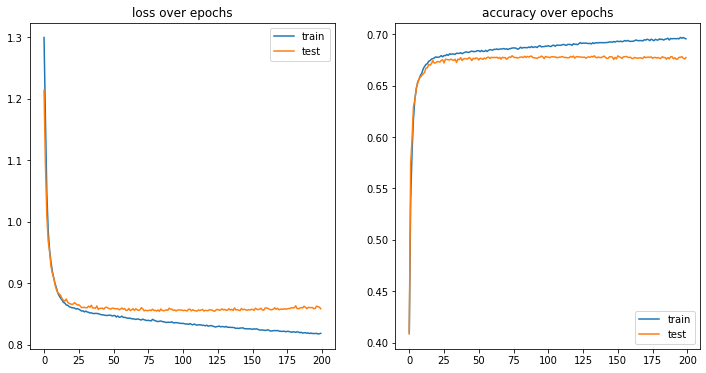

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].plot([k for k in range(200)], losses_per_epoch, label = 'train')
ax[0].plot([k for k in range(200)], [a.detach().numpy() for a in accs_test], label = 'test')
ax[0].set_title('loss over epochs')
ax[0].legend()
ax[1].plot([k for k in range(200)], accuracies_per_epoch, label = 'train')
ax[1].plot([k for k in range(200)], loss_test, label = 'test')
ax[1].set_title('accuracy over epochs')
ax[1].legend()

In [65]:
X_train.size(), y_train.size(), X_test.size(), y_test.size()

(torch.Size([107331, 4, 5]),
 torch.Size([429325, 4]),
 torch.Size([26833, 4, 5]),
 torch.Size([107332, 4]))

## simulating with custom inputs

In [14]:
def get_last_seq(person_df, choice_number, seq_len, debug_prints=False):
    """
    Gets a person's data and a choice number and returns a sequence of previous 4 (or seq_length) choices made (maybe not 4 (seq_length) consecutives)
    """
    if choice_number < seq_len:
        if debug_prints: print("must be {} and more to get a sequence".format(seq_len))
        return -2
    ind = np.where(person_df["orig_choice_num"] == choice_number)
    if len(ind[0]) == 0:
        if debug_prints: print("choice number {} not found".format(choice_number))
        return -9
    elif len(ind[0]) > 1:
        if debug_prints: print("FOR SOME REASON THERE'S MORE THAN ONE CHOICE NUMBER LIKE {}".format(choice_number))
        return -1
    # got here so I found the choice number , now lets check if we have 4 previous choices
    seq = []
    for i in range(ind[0][0] - seq_len + 1, ind[0][0] + 1, 1):
        seq.append(i)

    return person_df.iloc[seq]

In [15]:
def create_data_sequence(seq_df, seq_len):
    """
    gets a SINGLE sequence in df form and returns it in a train/test ready form (numpy) X and y
    """
    cur_data = seq_df.copy()
    cur_data['choice'] = cur_data.choice.apply(lambda x: x - 1)
    cur_data['prev_choice'] = cur_data.prev_choice.apply(lambda x: x - 1)
    X = cur_data.drop(
        columns=['choice', 'user', 'time', 'reward', 'payoff_structure', 'reward_1', 'reward_2', 'reward_3', 'reward_4',
                 'orig_choice_num'])
    X_prev = to_categorical(X.prev_choice, num_classes=4, dtype='int64')
    y = cur_data.choice
    num_of_classes = len(y.unique())
    y = to_categorical(y, num_classes=4, dtype='int64')

    new_X = []
    for prev_choice, prev_reward in zip(X_prev, X.prev_reward):
        new_i = np.append(prev_choice, prev_reward)
        new_X.append(new_i)
    new_X = np.array(new_X)

    # reshape X to be [samples, time steps, features]
    X_reshaped = np.reshape(new_X, (1, seq_length, new_X.shape[1]))
    y_reshaped = np.reshape(y, (1, seq_length, y.shape[1]))

    return X_reshaped, y_reshaped

In [16]:
def create_fake_sequence(seq, rewards, y=1):
    """
    seq - is the input : array with 4 ints in range 0-3
    rewards - are the corresponding rewards array at each time
    returns x, y in a sequence format
    """
    
    X_prev = to_categorical(seq, num_classes=4, dtype='int64')
    if y<0:
        y = random.randint(1, 4)
    y = to_categorical(y, num_classes=4, dtype='int64')

    new_X = []
    for prev_choice, prev_reward in zip(X_prev, rewards):
        new_i = np.append(prev_choice, prev_reward)
        new_X.append(new_i)
    new_X = np.array(new_X)

    # reshape X to be [samples, time steps, features]
    X_reshaped = np.reshape(new_X, (1, seq_length, new_X.shape[1]))
    y_reshaped = np.reshape(y, (1, seq_length))

    return X_reshaped, y_reshaped

In [17]:
def make_prediction(input_seq, input_rewards, print_to_screen=True, print_to_log=True):
    """
    input: a sequence and rewards , both as lists of ints
    returns: a prediction
    """
    fake_x, fake_y = create_fake_sequence(seq=input_seq,rewards=input_rewards)
    tf.reset_default_graph()
    model_fake = SinglesModel(is_training=False, output_size=4, batch_size=TRAIN_BATCHES, single_test=True)
    current_acc, current_loss, class_pred, correct_prediction, hidden_states, logits_test, softmax_test, outputs_test = model_fake.test_single(fake_x, fake_y, save_path, print_results=False)
    if print_to_screen:
        print("predicted class: ",class_pred[0])
        print(softmax_test)
        
    return (class_pred[0],softmax_test)

In [18]:
def run_fake_seq():
    """
    wrapper for running a new sequence
    if input is "exit" at any phase, exiting the outer loop
    """
    g = input("Enter a sequence of choices: ")
    if g == "exit":
        return 1
    input_seq = [int(x) for x in g.split()]
    r = input("Enter the corresponding rewards: ")
    if g == "exit":
        return 1
    input_rewards = [int(x) for x in r.split()]

    make_prediction(input_seq, input_rewards)
    
    return 0

In [19]:
def continuous_run():
    halt = 0
    while not halt:
        halt = run_fake_seq()

In [20]:
def split_prediction_argmax(cell):
    splitted_cell = cell.split()
    return int(splitted_cell[0]), float(splitted_cell[1].replace('[','').replace(']',''))

In [21]:
def produce_comparison_df(output_with_argmax, generated_output_with_argmax):
    predict_compare = []
    argmax_compare = []
    for gen_row, orig_row in zip(generated_output_with_argmax.to_numpy(), output_with_argmax.to_numpy()):
        row_predictions_compare = []
        row_argmax_compare = []
        for gen_out, orig_out in zip(gen_row, orig_row):
            gen_pred, gen_argmax = split_prediction_argmax(gen_out)
            orig_pred, orig_argmax = split_prediction_argmax(orig_out)
            row_predictions_compare.append(int(gen_pred==orig_pred))
            row_argmax_compare.append(np.abs(gen_argmax-orig_argmax))
        predict_compare.append(row_predictions_compare)
        argmax_compare.append(row_argmax_compare)
    
    predict_compare_df = pd.DataFrame(np.asmatrix(predict_compare), index=generated_output_with_argmax.index, columns=generated_output_with_argmax.columns)
    argmax_compare_df = pd.DataFrame(np.asmatrix(argmax_compare), index=generated_output_with_argmax.index, columns=generated_output_with_argmax.columns)
    return predict_compare_df, argmax_compare_df

In [22]:
################## V5.1 FULL #############################
# Patterns:
constant_group = ['1 1 1 1', '2 2 2 2', '3 3 3 3', '4 4 4 4']
one_different = ['2 2 2 1', '4 2 2 2', '2 2 2 4', '1 2 2 2', '3 2 2 2', '2 3 3 3', '2 1 1 1']
repeating_two = ['1 2 1 2', '2 1 2 1', '2 3 2 3', '3 2 3 2', '4 3 4 3', '3 4 3 4']
all_different = ['1 2 3 4', '4 3 2 1', '2 3 4 1', '1 4 3 2', '3 4 1 2', '2 1 4 3', '4 1 2 3', '3 2 1 4']

all_patterns_groups = [constant_group, one_different, repeating_two, all_different]


# Rewards:
constant_group_rew = ['10 10 10 10', '15 15 15 15', '20 20 20 20', '25 25 25 25', '30 30 30 30', '35 35 35 35',
                      '40 40 40 40', '45 45 45 45', '50 50 50 50', '55 55 55 55', '60 60 60 60', '65 65 65 65',
                      '70 70 70 70', '75 75 75 75', '80 80 80 80', '85 85 85 85', '90 90 90 90']

ascending_rew = ['10 20 30 40', '15 20 25 30', '10 30 50 70', '10 40 70 90', '30 35 40 45', '45 50 55 65',
                 '50 55 65 75', '55 65 75 85', '65 75 85 95', '75 80 85 90', '10 15 20 25', '25 45 65 85',
                 '40 60 80 90', '60 70 80 90', '20 30 70 80', '40 50 60 70', '50 60 70 80']

descending_rew = ['90 80 70 60', '80 70 60 50', '70 60 50 40', '60 50 40 30', '50 40 30 20', '40 30 20 10',
                  '90 70 50 30', '70 50 30 10', '95 75 55 35', '75 55 35 15', '80 60 40 20', '85 65 45 25',
                  '90 70 40 10', '90 60 30 10', '90 50 30 10', '90 40 30 20', '90 30 20 10', '60 30 20 10']


one_different_rew_good = ['10 10 10 90', '20 20 20 90', '30 30 30 90', '40 40 40 90', '50 50 50 90', '60 60 60 90', 
                          '10 10 90 10', '20 20 90 20', '30 30 90 30', '40 40 90 40', '50 50 90 50', '20 80 20 20',
                          '30 90 30 30', '60 90 60 60', '80 20 20 20', '90 30 30 30', '90 40 40 40', '90 50 50 50',
                          '20 20 20 80', '40 40 40 80', '60 60 60 80', '20 20 20 40', '40 40 40 60', '20 20 20 60',
                          '20 20 80 20', '40 40 80 40', '60 60 80 40', '20 20 40 20', '40 40 60 40', '20 20 60 20',
                          '20 80 20 20', '40 80 40 40', '60 80 60 60', '20 40 20 20', '40 60 40 40', '20 60 20 20',
                          '80 20 20 20', '80 40 40 40', '80 60 60 60', '40 20 20 20', '60 40 40 40', '60 20 20 20']


one_different_rew_bad = ['90 90 90 10', '90 90 90 20', '90 90 90 30', '90 90 90 40', '90 90 90 50', '90 90 90 60',
                         '90 90 10 90', '90 90 20 90', '90 90 30 90', '90 90 40 90', '90 90 50 90', '80 20 80 80',
                         '90 30 90 90', '90 60 90 90', '20 80 80 80', '30 90 90 90', '40 90 90 90', '50 90 90 90',
                         '80 80 80 20', '80 80 80 40', '80 80 80 60', '40 40 40 20', '60 60 60 40', '60 60 60 20',
                         '80 80 20 80', '80 80 40 80', '80 80 60 80', '40 40 20 40', '60 60 40 60', '60 60 20 60',
                         '80 20 80 80', '80 40 80 80', '80 60 80 80', '40 20 40 40', '60 40 60 60', '60 20 60 60',
                         '20 80 80 80', '40 80 80 80', '60 80 80 80', '20 40 40 40', '40 60 60 60', '20 60 60 60']


all_rewards_groups = [constant_group_rew, ascending_rew, descending_rew, one_different_rew_good, one_different_rew_bad]

In [23]:
all_rewards = []
for i in all_rewards_groups:
    for j in i:
        all_rewards.append(j)
        
all_patterns = []
for i in all_patterns_groups:
    for j in i:
        all_patterns.append(j)

In [24]:
new_check_df = pd.DataFrame(columns=all_rewards,index=all_patterns)

In [25]:
output_df = new_check_df.copy()
softmax_df = new_check_df.copy()
output_with_argmax = new_check_df.copy()
output_with_argmin = new_check_df.copy()

In [26]:
tf.reset_default_graph()

In [27]:
for index, row in new_check_df.iterrows():
    raw_index = [int(x)-1 for x in index.split()]    # since actual model gets 0-3
    raw_cols = [r.split() for r in list(row.index)]
#     print(index)
#     print(raw_index)
#     print(raw_cols[0])
    for orig_col in list(row.index):
        # convert current column to array
        cur_col = np.fromstring(orig_col, dtype=int, sep=' ')
        print(new_check_df.loc[index][orig_col])
        print(cur_col)
        row_col_pred, row_col_softmax = make_prediction(raw_index, cur_col)
        output_df.loc[index, orig_col] = row_col_pred+1
        softmax_df.loc[index, orig_col] = np.array2string(np.ravel(row_col_softmax), precision=3, separator=',', suppress_small=True)
        output_with_argmax.loc[index, orig_col] = str((row_col_pred+1)[0]) + " " + np.array2string(np.ravel(row_col_softmax)[row_col_pred], precision=3, separator=',', suppress_small=True)
        output_with_argmin.loc[index, orig_col] = str(np.argmin(np.ravel(row_col_softmax))+1) + " " + np.array2string(np.min(np.ravel(row_col_softmax)), precision=3, separator=',', suppress_small=True)
#     raw_cur_cols = [int(x) for x in raw_cols[0]]
#     make_prediction(raw_index, raw_cur_cols)
    

nan
[10 10 10 10]
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from saved_model/general_full_data_training/model_with_keras_batch2048
predicted class:  [1]
[array([[0.13712242, 0.46373987, 0.26035818, 0.13877949]], dtype=float32)]
nan
[15 15 15 15]
INFO:tensorflow:Restoring parameters from saved_model/general_full_data_training/model_with_keras_batch2048
predicted class:  [1]
[array([[0.28072828, 0.58374995, 0.08670615, 0.04881564]], dtype=float32)]
nan
[20 20 20 20]
INFO:tensorflow:Restoring parameters from saved_model/general_full_data_training/model_with_keras_batch2048
predicted class:  [0]
[array([[0.6834622 , 0

In [28]:
# output_df.to_csv(os.path.join('explain/','output_prediction.csv'))
# softmax_df.to_csv(os.path.join('explain/','output_softmax.csv'))
# output_with_argmax.to_csv(os.path.join('explain/','output_prediction_with_max_softmax.csv'))


#12.2.20
# output_df.to_csv(os.path.join('explain/','output_prediction_V3.csv'))
# softmax_df.to_csv(os.path.join('explain/','output_softmax_V3.csv'))
# output_with_argmax.to_csv(os.path.join('explain/','output_prediction_with_max_softmax_V3.csv'))

# 29.5.20
# output_df.to_csv(os.path.join(saving_dir,'output_prediction_V3.csv'))
# softmax_df.to_csv(os.path.join(saving_dir,'output_softmax_V3.csv'))
# output_with_argmax.to_csv(os.path.join(saving_dir,'output_prediction_with_max_softmax_V3.csv'))

# # 2.6.20
# output_df.to_csv(os.path.join(saving_dir,'output_prediction_V4.csv'))
# softmax_df.to_csv(os.path.join(saving_dir,'output_softmax_V4.csv'))
# output_with_argmax.to_csv(os.path.join(saving_dir,'output_prediction_with_max_softmax_V4.csv'))
# output_with_argmin.to_csv(os.path.join(saving_dir,'argmin_prediction_with_min_softmax_V4.csv'))


# 29.6.20
# output_df.to_csv(os.path.join(saving_dir,'output_prediction_V5.csv'))
# softmax_df.to_csv(os.path.join(saving_dir,'output_softmax_V5.csv'))
# output_with_argmax.to_csv(os.path.join(saving_dir,'output_prediction_with_max_softmax_V5.csv'))
# output_with_argmin.to_csv(os.path.join(saving_dir,'argmin_prediction_with_min_softmax_V5.csv'))

# 14.8.20
output_df.to_csv(os.path.join(saving_dir,'output_prediction_V5.1.csv'))
softmax_df.to_csv(os.path.join(saving_dir,'output_softmax_V5.1.csv'))
output_with_argmax.to_csv(os.path.join(saving_dir,'output_prediction_with_max_softmax_V5.1.csv'))
output_with_argmin.to_csv(os.path.join(saving_dir,'argmin_prediction_with_min_softmax_V5.1.csv'))